My implementation of Bayesian Regression and Active Learning strategy for CO2 emission predicton based on the car's volume and weight. 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [100]:
file_path = "/content/cars.csv"
data = pd.read_csv(file_path, delimiter = ',')

In [101]:
data.head()

,Car,Model,Volume,Weight,CO2
0,Toyoty,Aygo,1000,790,99
1,Mitsubishi,Space Star,1200,1160,95
2,Skoda,Citigo,1000,929,95
3,Fiat,500,900,865,90
4,Mini,Cooper,1500,1140,105


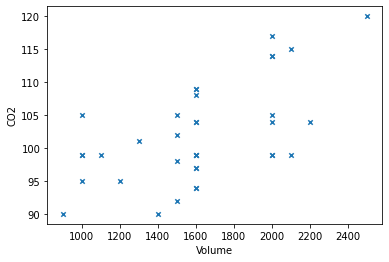

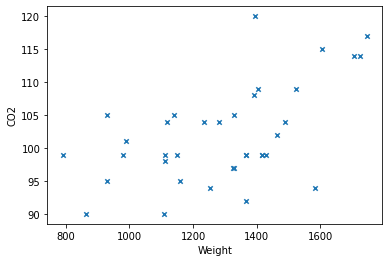

In [102]:
data.plot('Volume', 'CO2', kind = 'scatter', marker = 'x')
data.plot('Weight', 'CO2', kind = 'scatter', marker = 'x')

In [103]:
X_data = data[['Volume', 'Weight']].values
y_data = data[['CO2']].values

In [104]:
def x_preprocess(input_x):
    """
    Reshape the input (if needed), and prepend "1" to each observation
    
    Positional Argument:
        input_x -- a NumPy array, one- or two-dimensional
        
    """
    if input_x.ndim>=2:
        if np.shape(input_x)[0] < np.shape(input_x)[1]:
            input_x = input_x.T
        ones = np.ones((np.shape(input_x)[0],1))
        output = np.concatenate((ones, input_x), axis=1)
    else:
        ones = np.array([1])
        output = np.concatenate((ones, input_x))

  
    return output

In [ ]:
# Prepend a column of 1's to covariates matrix 
X_data_post = x_preprocess(X_data)

In [123]:
n_train = 30
# Training set
X_train = X_data_post[:n_train, :]
y_train = y_data[:n_train]
# Test set
X_test = X_data_post[n_train:, :]
y_test = y_data[n_train:]

In [124]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30, 3), (30, 1), (6, 3), (6, 1))

In [43]:
m = X_train.shape[0] # number of covariates
d = X_train.shape[1] # dimension of covariates 

## **Bayesian Linear Regression**

We have the following equation for the posterior probability of $w$, the linear regression parameter vector:

$$p(w|y, X) = N(w|\mu, \Sigma),$$

where

$$\Sigma = (\lambda \ I + \sigma^{- 2}\ X^T\ X)^{−1}$$

$$\mu = w_{MAP} = (\lambda \ \sigma^2 I + X^T\ X)^{-1}\ X^T y. $$

We don't know the true underlying parameter $\sigma^2$. It can be estimated by using the empirical deviation:

$$\sigma^2  = \frac{1}{n − d}\sum_{i=1}^n ( y_i − X_i w_{LS} )^2,$$  
where $w_{LS} = (X^T\ X)^{-1}\ X^T y$ is the least-squares estimate of $w$.

The prediction is made according to the predictive distribution:

$$p( y_0|x_0,y,X) = N(y_0|\mu_0,\sigma^2_0)$$  

$$\mu_0 = x^T_0\mu$$

$$ \sigma^2_0 = \sigma^2 + x_0^T\Sigma x_0.$$




In [15]:
def calculate_map_coefficients(aug_x, output_y, lambda_param, sigma_squared):
    """
    Calculate the maximum a posteriori LR parameters
    
     Positional arguments:
        aug_x -- x-matrix of training input data, augmented with column of 1's
        output_y -- vector of training output values
        lambda_param -- positive number; lambda parameter that
            controls how heavily to penalize large coefficient values
        sigma_squared -- data noise estimate
                
    Assumptions:
        -- output_y is a vector whose length is the same as the
        number of rows in input_x
        -- aug_x has more observations than it does features.
        -- lambda_param has a value greater than 0
    """
    
    x_transpose_x = np.matmul(aug_x.T,aug_x)
    Id = np.identity(np.shape(x_transpose_x)[0])
    inverse = np.linalg.inv(lambda_param*sigma_squared*Id + x_transpose_x)
    
    coefs = np.matmul(inverse, np.dot(aug_x.T,output_y))
    return coefs

In [16]:
def estimate_data_noise(aug_x, output_y, ml_weights):
    """Return empirical data noise estimate \sigma^2
    Use the LR weights in the equation supplied above
    
    Positional arguments:
        aug_x -- matrix of training input data
        output_y -- vector of training output values
        ml_weights = calculate_map_coefficients(aug_x, output_y, 0, 0)
    """
    error = output_y-np.dot(aug_x, ml_weights)
    sq_error = np.square(error)
    
    sig2 = 1.0/(np.shape(aug_x)[0]-np.shape(aug_x)[1])*np.sum(sq_error)
    
    return float(sig2)

In [17]:
def calc_post_cov_mtx(aug_x, sigma_squared, lambda_param):
    """
    Calculate the covariance of the posterior for Bayesian parameters.
    
    Positional arguments:
        aug_x -- matrix of training input data; preprocessed
        sigma_squared -- estimation of sigma^2
        lambda_param -- lambda parameter that controls how heavily
        to penalize large weight values
    
    """
    x_transpose_x = np.matmul(aug_x.T, aug_x)
    Id = np.identity(np.shape(x_transpose_x)[0])
    big_sigma_inv = lambda_param*Id + (1/sigma_squared)*x_transpose_x
    big_sigma = np.linalg.inv(big_sigma_inv)
    
    return big_sigma

In [22]:
def predict( aug_x, weights, big_sig, sigma_squared):
    """
    Calculate the point estimates and uncertainty for new values of x
    
    Positional Arguments:
        aug_x -- the augmented matrix of covariates for prediction
        weights -- MAP weights calculated from Bayesian LR
        big_sig -- The posterior covarience matrix, from Bayesian LR
        sigma_squared -- The observed uncertainty in Bayesian LR
    """
    mu_0 = np.dot(aug_x, weights)
    
    sigma_squared_0 = sigma_squared + np.dot(np.dot(aug_x.T, big_sig), aug_x)
    
    return mu_0, sigma_squared_0


In [19]:
lambda_param = 0.1

ml_weights = calculate_map_coefficients(X_train, y_train, 0, 0)

sigma_squared = estimate_data_noise(X_train, y_train, ml_weights)
        
map_weights = calculate_map_coefficients(X_train, y_train, lambda_param, sigma_squared)
        
big_sig = calc_post_cov_mtx(X_train, sigma_squared, lambda_param)

In [29]:
# Predict the output value y_pred and its uncertainty sigma_squared_0_pred
y_pred = []
sigma_squared_0_pred = []
for data in X_test:
  mu_0, sigma_squared_0 = predict(data, map_weights, big_sig, sigma_squared)
  y_pred.append(mu_0)
  sigma_squared_0_pred.append(sigma_squared_0)


y_pred = np.array(y_pred)
sigma_squared_0_pred = np.array(sigma_squared_0_pred)


In [33]:
# compute standard deviation from y_pred
std_pred = np.sqrt(sigma_squared_0_pred)

In [35]:
print(y_pred)
print(y_test)
print(std_pred)

[[119.33446327]
 [126.23824324]
 [ 96.8779665 ]
 [105.09302368]
 [105.88802922]
 [110.48147399]]
[[115]
 [117]
 [104]
 [108]
 [109]
 [120]]
[5.58626982 5.6627988  5.48073202 5.5152517  5.52592256 6.41302085]


In [42]:
# Accuracy metrics
mean_square_error = np.sqrt(np.sum(np.square(y_pred-y_test), axis=0))
print(mean_square_error)

[16.2355561]


## **Active Learning**

Update the predictive distribution sequentially

In [341]:
def update_posterior_sigma(sigma_prior, sigma_squared, x0):
  """
    Update the covariance and the mean of the posterior with a new covariate information.
    
    Positional arguments:
        sigma_prior -- covariance matrix of the prior distribution
        aug_x -- augmented matrix of the covariates
        sigma_squared -- estimation of sigma^2
        x_0 -- the covariates vector
  """
  # Compute the covariance
  sigma_posterior = 1/sigma_squared*np.outer(x0, x0)
  sigma_posterior = sigma_posterior + np.linalg.inv(sigma_prior)
  sigma_posterior = np.linalg.inv(sigma_posterior)
  return sigma_posterior

In [342]:
def uncertainty_evaluation(aug_x, sigma_prior, sigma_squared):
  """
    Evaluate the variance of covariate vectors for prediction
    
    Positional arguments:
        aug_x -- the augmented matrix of observations for predictions
        sigma_posterior -- the covariance matrix of the posterior
        sigma_squared -- estimation of sigma^2       
  """
  prediction_uncertainty = []
  for data in aug_x:
       uncertainty = float(sigma_squared+np.dot(np.dot(data.T,sigma_prior),data))
       prediction_uncertainty.append(uncertainty)
    
  return np.array(prediction_uncertainty)

In [343]:
def update_entropy(H_prior, sigma_squared, sigma_prior, x0):
  """
    Update the entropy of the posterior distribution
    
    Positional arguments:
        H_prior -- the entropy of the prior distribution
        sigma_squared -- estimation of sigma^2    
        sigma_prior -- the covariance of the prior distribution
        x0 -- a covariates vector    
  """
  d=len(x0)
  H_post = H_prior - d/2*np.log(1+(1/sigma_squared)*np.dot(np.dot(x0.T, sigma_prior), x0))
  return float(H_post)

### Greedy algorithm 

In [585]:
# Prepend a column of 1's to covariates matrix 
X_data_post = x_preprocess(X_data)

In [586]:
n_train = 30
# Training set
X_train = X_data_post[:n_train, :]
y_train = y_data[:n_train]
# Test set
X_test = X_data_post[n_train:, :]
y_test = y_data[n_train:]

In [587]:
X_test

array([[1.000e+00, 2.100e+03, 1.605e+03],
       [1.000e+00, 2.000e+03, 1.746e+03],
       [1.000e+00, 1.600e+03, 1.235e+03],
       [1.000e+00, 1.600e+03, 1.390e+03],
       [1.000e+00, 1.600e+03, 1.405e+03],
       [1.000e+00, 2.500e+03, 1.395e+03]])

In [588]:
# Run the Greedy algorithm
nn=X_test.shape[0]
kk=X_test.shape[1]

sigma_prior = big_sig

x_transpose_x = np.matmul(X_train.T, X_train)

entropy_hist = []

indices = []

X_test_pred = X_test

# Calculate initial entropy of the posterior distribution (becomes the prior in the sequential process)
H_prior = float(1/2*np.log(((np.e*np.pi)**d)*abs(np.linalg.det(big_sig))))

index_loop=0

x0_list=[]


In [589]:
while index_loop < nn:
    # select the index with maximal variance
    uncertainty = uncertainty_evaluation(X_test_pred, sigma_prior, sigma_squared);
    print(uncertainty)
    max_val = np.max(uncertainty)
    index_local = uncertainty.argmax(axis=0)
    # select a covariate with maximal uncertainty and measure the corresponding response
    x0 = X_test_pred[index_local,:]
    index_global = np.where((X_test == x0).all(axis=1))
    indices.append(index_global)
    y0 = y_test[index_global[0]]
    # update the training matrix and output vector
    X_train = np.vstack([X_train, x0])
    y_train = np.vstack([y_train, y0])
    # update the entropy 
    H_post = update_entropy(H_prior, sigma_squared, sigma_prior, x0)
    entropy_hist.append(H_post)
    H_prior = H_post
    # calculate new map weights
    weights = calculate_map_coefficients(X_train, y_train, lambda_param, sigma_squared) 
    # update the posterior distribution covariance matrix
    sigma_post = update_posterior_sigma(sigma_prior, sigma_squared, x0)
    sigma_prior = sigma_post
    X_test_pred=np.delete(X_test_pred, index_local, axis=0)
    # predict the output 
    index_loop+=1

[31.2064105  32.06729028 30.03842349 30.4180013  30.53582009 41.1268364 ]
[30.96161944 32.06193057 29.93551094 30.41395807 30.52566246]
[30.84378098 29.90667826 30.30147452 30.40217354]
[29.8721067  30.26248806 30.36274575]
[29.85361708 30.20719155]
[29.83612598]


In [590]:
sigma_prior

array([[ 7.09707702e+00, -1.71953124e-04, -5.09649020e-03],
       [-1.71953124e-04,  1.26672146e-05, -1.56487088e-05],
       [-5.09649020e-03, -1.56487088e-05,  2.37712431e-05]])

In [591]:
print(calc_post_cov_mtx(X_data_post, sigma_squared, lambda_param))
# We can see that both matrices are equal

[[ 7.09707702e+00 -1.71953124e-04 -5.09649020e-03]
 [-1.71953124e-04  1.26672146e-05 -1.56487088e-05]
 [-5.09649020e-03 -1.56487088e-05  2.37712431e-05]]


In [592]:
weights

array([[2.31347672e+01],
       [9.17563505e-03],
       [4.81672771e-02]])

In [593]:
print(calculate_map_coefficients(X_data_post, y_data, lambda_param, sigma_squared))
# We can see that both vectors are equal 

[[2.31347672e+01]
 [9.17563505e-03]
 [4.81672771e-02]]


Text(0, 0.5, 'Entropy')

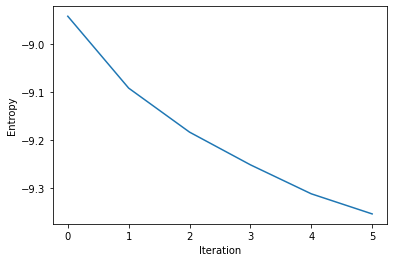

In [596]:
plt.plot(entropy_hist)
plt.xlabel('Iteration')
plt.ylabel('Entropy')